In [ ]:
# This one got accuracies of...
# LogisticRegression = Accuracy: 0.9138
# SVM = Accuracy: 0.9457
# KNN = Accuracy: 0.9419
# RANDOM FOREST = Accuracy: 0.9366
# DECISION TREE = Accuracy: 0.8695
# Naive Bayes = Accuracy: 0.8890
# Gradient Boosting = Accuracy: 0.9242


# raw_path = 'cv-corpus-10.0-delta-2022-07-04/en/clips'           # simply the .mp3 files
# label_path = 'cv-corpus-10.0-delta-2022-07-04/en/validated.tsv' # contains the gender labels

In [19]:
import sklearn
print(sklearn.__version__)

1.7.1


# RAW DATA IMPORT
**total distributions**

male = 3469 | 
femal =  3216

In [175]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm  # <-- for progress bar

raw_path = 'training_dataset/cv-corpus-16.1-delta-2023-12-06/en/clips'
label_path = 'training_dataset/cv-corpus-16.1-delta-2023-12-06/en/validated.tsv'

df = pd.read_csv(label_path, sep='\t')
labels = df[df['gender'].isin(['male', 'female'])].copy() #of the 50,000+ samples in the directory, just pick those that are already labeled
labels['mp3_path'] = labels['path'].apply(lambda x: os.path.join(raw_path, x))

def add_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        duration = librosa.get_duration(y=y, sr=sr)

        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch_values = pitches[magnitudes > np.median(magnitudes)]
        pitch_mean = np.mean(pitch_values) if pitch_values.size > 0 else 0

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y))

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_features = {f"mfcc_{i+1}": mfcc_mean[i] for i in range(len(mfcc_mean))}

        return pd.Series({
            'duration_sec': duration,
            'mean_pitch': pitch_mean,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_flatness': spectral_flatness,
            **mfcc_features
        })

    except Exception:
        return pd.Series({
            'duration_sec': np.nan,
            'mean_pitch': np.nan,
            'spectral_centroid': np.nan,
            'spectral_bandwidth': np.nan,
            'spectral_flatness': np.nan,
            **{f"mfcc_{i+1}": np.nan for i in range(13)}
        })


# Feature extraction with progress bar

features = []

for file_path in tqdm(labels['mp3_path'], desc="Extracting features"):
    features.append(add_features(file_path))

features_df = pd.DataFrame(features)
audio_df = pd.concat([labels.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

print("Feature extraction complete")


Extracting features: 100%|█████████████████████████████████████████████████████████| 3026/3026 [02:50<00:00, 17.78it/s]


Feature extraction complete


# DATA CLEANING

In [141]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           3026 non-null   object 
 1   path                3026 non-null   object 
 2   sentence            3026 non-null   object 
 3   up_votes            3026 non-null   int64  
 4   down_votes          3026 non-null   int64  
 5   age                 3025 non-null   object 
 6   gender              3026 non-null   object 
 7   accents             2950 non-null   object 
 8   variant             0 non-null      float64
 9   locale              3026 non-null   object 
 10  segment             0 non-null      float64
 11  mp3_path            3026 non-null   object 
 12  duration_sec        3026 non-null   float64
 13  mean_pitch          3026 non-null   float64
 14  spectral_centroid   3026 non-null   float64
 15  spectral_bandwidth  3026 non-null   float64
 16  spectr

In [143]:
print(f'{audio_df['gender'].value_counts()}')
print(f'{audio_df.gender.unique()}')

gender
male      1528
female    1498
Name: count, dtype: int64
['male' 'female']


# Modeling Part

In [66]:
x = audio_df[['mean_pitch', 'spectral_centroid',
             'spectral_bandwidth', 'spectral_flatness'] + [f'mfcc_{i}' for i in range(1, 14)]]
y = audio_df['gender']

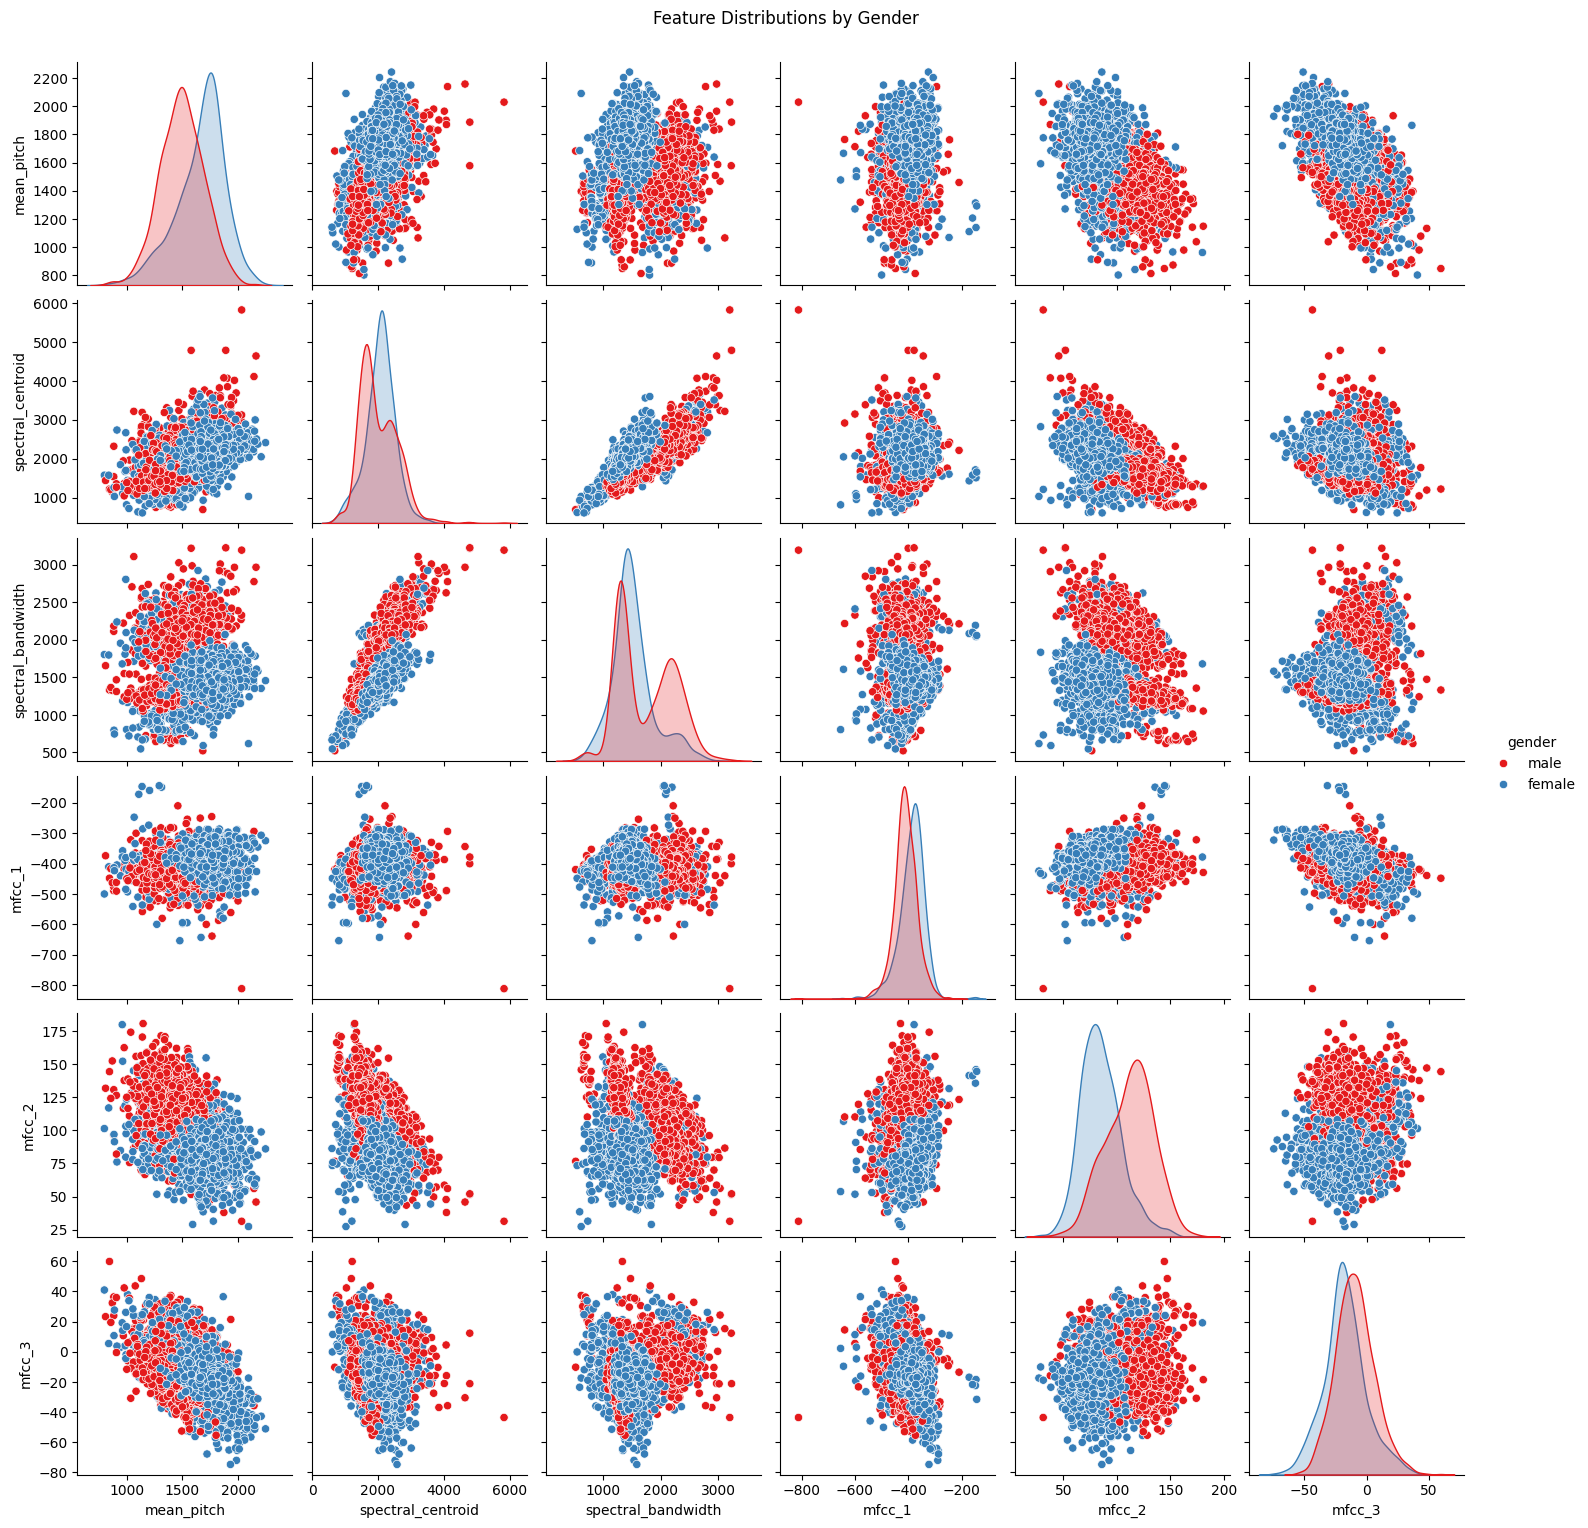

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
selected_features = ['mean_pitch', 'spectral_centroid', 'spectral_bandwidth', 'mfcc_1', 'mfcc_2', 'mfcc_3']

sns.pairplot(audio_df[selected_features + ['gender']], hue='gender', palette='Set1')
plt.suptitle('Feature Distributions by Gender', y=1.02)
plt.show()

## Using RandomForest

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# data splitting
labelencoder = LabelEncoder()
y_enc = labelencoder.fit_transform(y)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_enc, test_size=0.3, random_state=42)

# Random Forest model training
model = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# accuracy testing
accuracy = accuracy_score(y_test, y_pred)
_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=labelencoder.classes_)
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", _matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.9537

Confusion Matrix:
 [[418  22]
 [ 20 448]]

Classification Report:
               precision    recall  f1-score   support

      female       0.95      0.95      0.95       440
        male       0.95      0.96      0.96       468

    accuracy                           0.95       908
   macro avg       0.95      0.95      0.95       908
weighted avg       0.95      0.95      0.95       908



test to hello_dataset using Random Forest

In [152]:
import os
import pandas as pd
from tqdm import tqdm  # progress bar
from sklearn.ensemble import RandomForestClassifier

hello_path = "hello_dataset"
hello_files = [os.path.join(hello_path, f) for f in os.listdir(hello_path) if f.endswith(".wav")]

print(f"Found {len(hello_files)} clips")


hello_features = []

for file in tqdm(hello_files, desc="Extracting features"):
    feat = add_features(file)  # reuse your feature extraction function
    feat['file_path'] = file
    hello_features.append(feat)

hello_df = pd.DataFrame(hello_features)


feature_columns = x.columns  # features used in training
X_hello = hello_df[feature_columns]  # select only matching columns


X_hello_scaled = scaler.transform(X_hello)


y_hello_pred = model.predict(X_hello_scaled)
y_hello_labels = labelencoder.inverse_transform(y_hello_pred)

hello_df['predicted_gender'] = y_hello_labels


hello_df[['file_path', 'predicted_gender']]


Found 13 clips


Extracting features: 100%|█████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.36it/s]


,file_path,predicted_gender
0,hello_dataset\Adele - Hello - HQ Studio Acapel...,male
1,hello_dataset\DON'T BLINK... THIS GAME IS WATC...,male
2,hello_dataset\DON'T BLINK... THIS GAME IS WATC...,male
3,hello_dataset\hello_ken.wav,male
4,"hello_dataset\In Project Zomboid, the fire off...",male
5,hello_dataset\mikudayo.wav,female
6,hello_dataset\Nothing beats a jet2 holiday😌.wav,female
7,hello_dataset\Oh my gah!.wav,male
8,hello_dataset\philomena.wav,female
9,hello_dataset\poteto.wav,female


## Using Support Vector Machines (SVM) with RBF kernel

eto talaga yung magandang goto model since overlapping mga features natin, using \
RBF kernel is that it can modify it such that more wiggle room pa yung model imbis \
na linearly lang pag categorize.

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC # the model used

# data splitting
labelencoder = LabelEncoder()
y_enc = labelencoder.fit_transform(y)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_enc, test_size=0.3, random_state=42)

# SVM model training
model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# accuracy testing
accuracy = accuracy_score(y_test, y_pred)
_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=labelencoder.classes_)
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", _matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.9692

Confusion Matrix:
 [[426  14]
 [ 14 454]]

Classification Report:
               precision    recall  f1-score   support

      female       0.97      0.97      0.97       440
        male       0.97      0.97      0.97       468

    accuracy                           0.97       908
   macro avg       0.97      0.97      0.97       908
weighted avg       0.97      0.97      0.97       908



test to hello_dataset using SVM with RBF kernel

In [173]:
import os
import pandas as pd
from tqdm import tqdm  # progress bar

# Path to hello clips
hello_path = "hello_dataset"
hello_files = [os.path.join(hello_path, f) for f in os.listdir(hello_path) if f.endswith(".wav")]

print(f"Found {len(hello_files)} clips")

# Extract features with progress bar
hello_features = []

for file in tqdm(hello_files, desc="Extracting features"):
    feat = add_features(file)  # your feature extraction function
    feat['file_path'] = file
    hello_features.append(feat)

hello_df = pd.DataFrame(hello_features)


feature_columns = x.columns  # features used in SVM training
X_hello = hello_df[feature_columns]  # select only matching columns

# Scale features using the same scaler from training
X_hello_scaled = scaler.transform(X_hello)

# Predict with trained SVM model
y_hello_pred = model.predict(X_hello_scaled)

# Decode numeric labels back to original ('male', 'female')
y_hello_labels = labelencoder.inverse_transform(y_hello_pred)

# Add predictions to DataFrame
hello_df['predicted_gender'] = y_hello_labels

# Output DataFrame
hello_df[['file_path', 'predicted_gender']]


Found 14 clips


Extracting features: 100%|█████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.65it/s]


,file_path,predicted_gender
0,hello_dataset\Adele - Hello - HQ Studio Acapel...,male
1,hello_dataset\Adele - Hello - HQ Studio Acapel...,male
2,hello_dataset\DON'T BLINK... THIS GAME IS WATC...,male
3,hello_dataset\DON'T BLINK... THIS GAME IS WATC...,male
4,hello_dataset\hello_ken.wav,male
5,"hello_dataset\In Project Zomboid, the fire off...",male
6,hello_dataset\mikudayo.wav,male
7,hello_dataset\Nothing beats a jet2 holiday😌.wav,male
8,hello_dataset\Oh my gah!.wav,male
9,hello_dataset\philomena.wav,female


## K-Nearest Neighbors (KNN)

idk why pero maganda sya lmao

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier # the model used

# data splitting
labelencoder = LabelEncoder()
y_enc = labelencoder.fit_transform(y)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_enc, test_size=0.3, random_state=42)

# KNN model training
model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)  # Euclidean distance
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# accuracy testing
accuracy = accuracy_score(y_test, y_pred)
_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=labelencoder.classes_)
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", _matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.9681

Confusion Matrix:
 [[432   8]
 [ 21 447]]

Classification Report:
               precision    recall  f1-score   support

      female       0.95      0.98      0.97       440
        male       0.98      0.96      0.97       468

    accuracy                           0.97       908
   macro avg       0.97      0.97      0.97       908
weighted avg       0.97      0.97      0.97       908



test to hello_dataset with KNN model

In [171]:
import os
import pandas as pd

# Path to hello clips
hello_path = "hello_dataset"
hello_files = [os.path.join(hello_path, f) for f in os.listdir(hello_path) if f.endswith(".wav")]

print(f"Found {len(hello_files)} clips")

# Extract features using add_features() function
hello_features = []

for file in hello_files:
    feat = add_features(file)
    feat['file_path'] = file  # track file names
    hello_features.append(feat)

hello_df = pd.DataFrame(hello_features)

# x = training features used to train KNN
feature_columns = x.columns  
# select only matching columns
X_hello = hello_df[feature_columns] 

# Scale features using the same scaler
X_hello_scaled = scaler.transform(X_hello)

# Predict with trained KNN model
y_hello_pred = model.predict(X_hello_scaled)

# Decode numeric labels back to original
y_hello_labels = labelencoder.inverse_transform(y_hello_pred)

# Add predictions to DataFrame
hello_df['predicted_gender'] = y_hello_labels

# Output DataFrame
hello_df[['file_path', 'predicted_gender']]


Found 14 clips


,file_path,predicted_gender
0,hello_dataset\Adele - Hello - HQ Studio Acapel...,male
1,hello_dataset\Adele - Hello - HQ Studio Acapel...,male
2,hello_dataset\DON'T BLINK... THIS GAME IS WATC...,male
3,hello_dataset\DON'T BLINK... THIS GAME IS WATC...,male
4,hello_dataset\hello_ken.wav,male
5,"hello_dataset\In Project Zomboid, the fire off...",male
6,hello_dataset\mikudayo.wav,male
7,hello_dataset\Nothing beats a jet2 holiday😌.wav,male
8,hello_dataset\Oh my gah!.wav,male
9,hello_dataset\philomena.wav,female
